## 17 Oct 2018
--Laurin Gray

This is a copy of the Three-Sigma_Red-Excess_3Oct2018 notebook, with adjustments to certain cells, marked with # ******** at the top when I made a change to that cell.  Hopefully me fixing it here will be easier than trying to communicate to you exactly what to change, especially since I have some more automizations that might be a little hard to explain.

Note that I haven't included much modification for the [24] vs. [8.0]-[24] CMD- the shape is so different from all the others that I'm not even sure how well these routines will work on it.

Also I put numbers at the top of all the cells so that it's easier to refer to them- they should be in the exact same order as in your notebook.

In [ ]:
#1

########## 3 October 2018 - Alec S. Hirschauer ##########
# Today I am going to make three-sigma red-excess boundary lines for
# four color-magnitude diagrams (CMDs) made from the near- and mir-IR
# photometric data of the neary, metal-poor, star-forming dwarf galaxy
# NGC 6822 from Sibbons+ (2012) and Khan+ (2015), respectively.
#
# This notebook will utilize the techniques developed by my SASP student
# Laurin Gray this summer for our project identifying AGB star candidates
# in NGC 6822, albeit using different near-IR data and fewer CMDs.
#
# Rather than the eight we used this summer, we will use just four:
# CMD_1: K vs J-K
# CMD_2: [3.6] vs J-[3.6]
# CMD_3: [8.0] vs [3.6]-[8.0]
# CMD_4: [8.0] vs J-[8.0]
# CMD_5: [24] vs [8.0] - [24]
# CMD_6: [8.0] vs [4.5] - [8.0]

In [3]:
#2

# First thing needed is to import the relevant Python libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import gaussian_kde
# This line is necessary for the number density histograms.
#from astropy import stats
#from astropy.stats.histogram import knuth_bin_width
# These lines are necessary for determining histogram bin width, I think.
import csv
import pathlib
# These lines are from Laurin's notebook preamble.

In [4]:
#3

# For the histograms, I have created new .csv files which have the specific colors'
# information: ID, RA, Dec, magnitudes, magnitude errors, color, color error.
#
# I have pre-trimmed the bogus data from these tables already, so there's no need
# to get rid of the whacky 'null' values converted to "-9999" values
# (which, when subtracted from any other value, gives another bogus value)
# like I did in the previous cell with the "full" catalog.
#
jMINUSkDATA = pd.read_csv("C:\\Users\\Laurin\\Documents\\STSCI_Internship\\NGC6822_LG\\Phot_data\\Khan+Sibbons\\jMINUSk.csv")
jMINUSthreesixDATA = pd.read_csv("C:\\Users\\Laurin\\Documents\\STSCI_Internship\\NGC6822_LG\\Phot_data\\Khan+Sibbons\\jMINUSthreesix.csv")
threesixMINUSeightzeroDATA = pd.read_csv("C:\\Users\\Laurin\\Documents\\STSCI_Internship\\NGC6822_LG\\Phot_data\\Khan+Sibbons\\threesixMINUSeightzero.csv")
jMINUSeightzeroDATA = pd.read_csv("C:\\Users\\Laurin\\Documents\\STSCI_Internship\\NGC6822_LG\\Phot_data\\Khan+Sibbons\\jMINUSeightzero.csv")
#
# After comparing cells where I made CMDs with the "filter_phot_data" data and with
# the specific colors' information above, I have found that they are the same!
# I will use these data instead of calling from the larger catalog.
#
# These two were made following a meeting with Margaret on 2 October 2018.
eightzeroMINUStwentyfourDATA = pd.read_csv("C:\\Users\\Laurin\\Documents\\STSCI_Internship\\NGC6822_LG\\Phot_data\\Khan+Sibbons\\eightzeroMINUStwentyfour.csv")
fourfiveMINUSeightzeroDATA = pd.read_csv("C:\\Users\\Laurin\\Documents\\STSCI_Internship\\NGC6822_LG\\Phot_data\\Khan+Sibbons\\fourfiveMINUSeightzero.csv")
#
# **************************************************
#
# ^ This above cell was copy + pasted from my earlier CMDs notebook, which as an
# alternative to the whole joined catalog, has trimmed out bogus values by hand
# which might interfere with the statistics pertinent to this project.

In [5]:
#4

# Read in my data from a .csv file saved locally.
#phot_data = pd.read_csv('CMDKhanANDSibbonsHOME_ahirschauer.csv')
# This is a table of values with 30,745 rows which contains the photometric data of
# the Khan et al. (2015) catalog matched to sources from Sibbons et al. (2012)
# with an "OR" command, then downloaded from MAST CasJobs.
# print phot_data
#
# Also I'll read in the entire Sibbons+ stellar source catalog.
#Sibbons_data = pd.read_csv('Sibbons2012NGC6822.csv')
# This is for a test of the histogram(s) I make later on.
#
# **************************************************
#
# ^ This above cell was copy + pasted from my earlier CMDs notebook, and is here
# as a backup in case I need something more than the trimmed .csv files can provide.

In [6]:
#5

# NB: Laurin's notebook includes definitions calculating color values and color errors
# from the original photometric data at this point, however with my .csv files above
# these values are all already computed and in the tables, so I'll skip this step.
#
# Furthermore, she includes a filtering step which throws out dummy placeholder values
# in the table(s) = +/-9999, but I have found that this step generally creates more of
# a headache than it attempts to alleviate, so I am skipping this step as well.

In [7]:
#6

# ***********************************************************************************************************
# I altered which CMDs y1 is set differently for -LG

### FUNCTION DEFINITIONS ###
#
# Here I am copying the routine written by Laurin Gray, modifying them to work with the
# new data and new CMDs that we are employing now.

def create_bins(bin_size, y1, y2, xval, yval, err):
    
    n_bins = (y2 - y1)/bin_size
    # print(n_bins)
    
    if n_bins%1 == 0:
        n_bins = int(n_bins)
    else:
        print("Error: n_bins is not a whole number!  Choose a different range or bin size.")
        
    y_bins = [[] for x in range(0,n_bins)] # y-values
    x_bins = [[] for x in range(0,n_bins)] # x-values
    e_bins = [[] for x in range(0,n_bins)] # errors
    c_bins = [[] for x in range(0,n_bins)] # IDs
    
    # print(y_bins)
    
    c=0 #row counter
    for i in yval:
        k = 0 #bin counter
        if yval is jMINUSthreesixDATA.k36mag.values: # CMD_3 has a y1 of 10.0 in CMD notebook -LG
            y1 = 8.5
        elif yval is eightzeroMINUStwentyfourDATA.k24mag.values: # from CMD notebook -LG
            y1 = 2.0
        elif yval is fourfiveMINUSeightzeroDATA.k80mag.values: # also from CMD notebook -LG
            y1 = 7.5
        else:
            y1 = 10.0
        while k < n_bins:
            if y1 <= i < y1+bin_size:
                y_bins[k].append(i)
                x_bins[k].append(xval[c])
                e_bins[k].append(err[c])
                c_bins[k].append(ID[c])
                y1 = y1+bin_size
                k = k+1
            else:
                y1 = y1+bin_size
                k = k+1
        c = c+1
        
    return y_bins, x_bins, e_bins, c_bins

# The above creates bins to hold selected x-values, y-values, and errors, along with the
# coordinate ID, depending on the range of y-values they fall into.  These bins are then
# filled with said values, and the bins are returned.
#
# The user enters the size of the bin they would like, the range of data to cover, the
# x- and y-axes of the CMD, and the error associated with the x-axis (color term).
#
# Note that it is impossible to create bins that will have no values in them; these will
# simply hold a NaN value, and not create a 3-sigma boundary for that range.
#
# The bin size and range must be chosen so that the number of bins comes out as a whole
# number.  If this is not the case, an error message will print.
#
# "y1" must be lower than "y2".  "xval", "yval", and "err" take the form
# "Kmag", "jMINUSk", or "ERRORjMINUSk".
#
# An example of a calling function: create_bins(0.5, 10.0, 20.0, jMINUSk, Kmag, ERRORjMINUSk)

In [8]:
#7

def vert_mean(mag_lim, xval, yval):
    
    mean = []

    c=0
    for i in yval:
        if i < mag_lim:
            mean.append(xval[c])
            c = c+1
        else:
            c = c+1

    bound = np.nanmean(mean)
    stdev = np.nanstd(mean)

    left = bound - 3.0*stdev
    right = bound + 3.0*stdev

    clip = [] # sigma-clipped array
    for k in mean:
        if left < k < right:
            clip.append(k)

    boundary = np.nanmean(clip) #this is the average value of the points above K=15
    #print(boundary)
    
    return boundary

# The above determines the vertical line of the data; the average of the vertical branch.
# To mitigate the effects of other branches, select a mag_lim that excludes where the
# points diverge.
#
# Example of a calling function: vert_mean(15.0, jMINUSk, Kmag)

In [9]:
#8

def bound_shift(boundary):
    
    threesig = []
    for i in e_bin:
        threesig.append(np.nanmean(i)*3)
    
    # make list of red limit values
    redlim = []

    for i in threesig:
        redlim.append(boundary+i)
    
    #print(redlim)
    return redlim

# The above creates boundaries in regions that are 3-sigma away from the vertical mean.
# Input is the return of the vertical mean function.
#
# If any bins are empty, this function will return a RuntimeWarning: Mean of empty slice.
# This is fine, it just holds a NaN value in that spot and won't plot a boundary there.
#
# Example of a calling function: bound_shift(boundary)

In [10]:
#9

# ***************************************************************************************************
# All I changed here was adding the LATEX syntax to the labels so we could have Ks

def plot_CMD(xaxis, yaxis, color='gray'):
    
    # set axis limits & names (so I don't have to do it manually each time I plot)
    
    if yaxis is jMINUSkDATA.Kmag.values: # CMD_1
        y1 = 10.0
        y2 = 20.0
        ylabel = '$K_s$'
    elif yaxis is jMINUSthreesixDATA.k36mag.values: # CMD_2
        y1 = 8.5
        y2 = 20.5
        ylabel = '[3.6]'
    elif yaxis is threesixMINUSeightzeroDATA.k80mag.values: # CMD_3
        y1 = 10.0
        y2 = 18.0
        ylabel = '[8.0]'
    elif yaxis is jMINUSeightzeroDATA.k80mag.values: # CMD_4
        y1 = 10.0
        y2 = 18.0
        ylabel = '[8.0]'
    elif yaxis is eightzeroMINUStwentyfourDATA.k24mag.values: # CMD_5
        y1 = 2.0
        y2 = 16.5
        ylabel = '[24]'
    elif yaxis is fourfiveMINUSeightzeroDATA.k80mag.values: # CMD_6
        y1 = 7.5
        y2 = 18.0
        ylabel = '[8.0]'
    
    if xaxis is jMINUSkDATA.jMINUSk.values: # CMD_1
        x1 = -0.5
        x2 = 4.0
        xlabel = '$J$ - $K_s$'
    elif xaxis is jMINUSthreesixDATA.jMINUSthreesix.values: # CMD_2
        x1 = -1.0
        x2 = 6.0
        xlabel = '$J$ - [3.6]'
    elif xaxis is threesixMINUSeightzeroDATA.threesixMINUSeightzero.values: # CMD_3
        x1 = -2.5
        x2 = 7.5
        xlabel = '[3.6] - [8.0]'
    elif xaxis is jMINUSeightzeroDATA.jMINUSeightzero.values: # CMD_4
        x1 = -1.0
        x2 = 7.5
        xlabel = '$J$ - [8.0]'
    elif xaxis is eightzeroMINUStwentyfourDATA.eightzeroMINUStwentyfour.values: # CMD_5
        x1 = -3.0
        x2 = 11.0
        xlabel = '[8.0] - [24]'
    elif xaxis is fourfiveMINUSeightzeroDATA.fourfiveMINUSeightzero.values: # CMD_6
        x1 = -1.5
        x2 = 6.5
        xlabel = '[4.5] - [8.0]'

    plt.figure(figsize=(12,12))
    plt.plot(xaxis,yaxis,',', color=color)
    plt.xlim(x1, x2)
    plt.ylim(y2, y1)
    plt.xlabel(xlabel, size=22)
    plt.ylabel(ylabel, size=22)
    plt.tick_params(labelsize=17)
    
# The above plots the CMDs.  We have pre-set the axes limits/labels.

In [11]:
#10

# ****************************************************************************************************************
# At some point in a later cell, I'm going to define a variable called "bin_lim" for the cases when we have 
# a lower magnitude limit (on the [8.0] vs. CMDs specifically, as well as CMD_5), because I have a feeling it'll be
# slightly different across those 4 CMDs, and also it's a pain to change it everywhere whenever you want to change 
# the limit -LG

def data_flag():
    
    IDs = [] #empty set to store IDs

    k=0
    
    if yaxis is jMINUSeightzeroDATA.k80mag.values:
        for i in x_bin[:bin_lim]: # 1st instance of bin_lim
            coord = c_bin[k]
            c=0
            for x in i:
                if x > redlim[k]:
                    IDs.append(coord[c])
                    c=c+1
                else: 
                    c=c+1
            k = k+1
    elif yaxis is threesixMINUSeightzeroDATA.k80mag.values:
        for i in x_bin[:bin_lim]: # 1st instance of bin_lim
            coord = c_bin[k]
            c=0
            for x in i:
                if x > redlim[k]:
                    IDs.append(coord[c])
                    c=c+1
                else: 
                    c=c+1
            k = k+1
        
    elif yaxis is fourfiveMINUSeightzeroDATA.k80mag.values:
        for i in x_bin[:bin_lim]: # 1st instance of bin_lim
            coord = c_bin[k]
            c=0
            for x in i:
                if x > redlim[k]:
                    IDs.append(coord[c])
                    c=c+1
                else: 
                    c=c+1
            k = k+1
            
    elif yaxis is eightzeroMINUStwentyfourDATA.k24mag.values:
        for i in x_bin[:bin_lim]: # 1st instance of bin_lim
            coord = c_bin[k]
            c=0
            for x in i:
                if x > redlim[k]:
                    IDs.append(coord[c])
                    c=c+1
                else: 
                    c=c+1
            k = k+1
    
    else:
        for i in x_bin:
            coord = c_bin[k]
            c=0
            for x in i:
                if x > redlim[k]:
                    IDs.append(coord[c])
                    c=c+1
                else: 
                    c=c+1
            k = k+1
            
    print("Number of flagged points:", len(IDs))
    #print("IDs of points:", IDs)
    return IDs

# The above evaluates and flags points that are redward of the 3-sigma boundary.
# IDs of flagged points are then stored in a list and returned.
#
# It is suggested that when you call the function to a variable, you name it in
# the format "threesix_VS_jMINUSthreesix", as this will make it easier to tell
# which datasets belong to which CMDs when they are all in the same file.
#
# Example of a calling function: threesix_VS_jMINUSthreesix = data_flag()

In [12]:
#11

def save_data(dataset, column=''):
    
    if path.exists():
        flagged_points = pd.read_csv(filename)
        new_points = pd.DataFrame({column:dataset})

        flagged_points= pd.concat([flagged_points, new_points], axis=1)
        flagged_points.to_csv(filename, index=False)
    else:
        f = open(filename, 'w', newline="")
        writer = csv.writer(f)
        #add heading
        points_w_header = [column] + dataset

        for val in points_w_header:
            writer.writerow([val])

        f.close()

# The above checks if the data file already exists.  If it does, it adds the data
# on as a new column with a header you set when you call the function.
# If it doesn't, it creates the file and adds the data to it.
#
# Example of a calling function: save_data(threesix_VS_jMINUSthreesix, column='threesix_VS_jMINUSthreesix')

In [13]:
#12

### RUN DATA ###
#
# Every time you run a new set of data, make sure to change:
#
# [1] y1
# [2] y2
# [3] lim
# [4] xaxis
# [5] yaxis
# [6] error
# [7] column name
#
# for CMD_1: y1 = 10.0, y2 = 20.0
# for CMD_2: y1 = 8.5, y2 = 20.5
# for CMD_3: y1 = 10.0, y2 = 18.0
# for CMD_4: y1 = 10.0, y2 = 18.0
# for CMD_5: y1 = 2.0, y2 = 16.5
# for CMD_6: y1 = 7.5, y2 = 18.0
#
# From Laurin's comments:
## "Lim doesn't matter for [8.0] vs. CMDs, because it will be set manually.
## Lim for [3.6] vs. J-[3.6] & K vs. H-K is 14.0, lim for H vs. J-H & K vs. J-K is 14.5,
## lim for H vs. H-[3.6] & H vs. H-[4.5] is 15.0"
#
# ^ Since the majority of these CMDs aren't going to be used in our current situation,
# I guess these 'lim' values don't really apply to us.
# But for [8.0] vs J-[8.0], I guess it's being set manually?
#
# UPDATE: Now, three of the xis CMDs use [8.0] on the y-axis.


## ^ I'm going to say lim = 14.5 for CMD_1 and lim = 14.0 for CMD_2 are still okay, but I think everything else 
# will need to have their vertical mean set manually -LG

In [22]:
#13

# ***************************************************************************************************************
# Added one more variable, low_lim, used for calculating bin_lim -LG

filename = "C:\\Users\\Laurin\\Documents\\STSCI_Internship\\NGC6822_LG\\Phot_data\\Khan+Sibbons\\flagged_values_26Oct2018_lgray.csv"
#'/Users/ahirschauer/Documents/Year2/09-2018/NGC6822/flagged_values_1Oct2018_ahirschauer.csv'
path = pathlib.Path(filename)

y1 = 8.5
y2 = 20.5
bin_size = 0.1
lim = 14.0 # limit above which the vertical branch mean is calculated
xaxis = jMINUSthreesixDATA.jMINUSthreesix.values
yaxis = jMINUSthreesixDATA.k36mag.values
error = jMINUSthreesixDATA.ERRORjMINUSthreesix.values
ID = jMINUSthreesixDATA.ID.values
column = 'threesix_VS_jMINUSthreesix'

low_lim = 15.4 # limit below which points are excluded (clumping).  Should be placed at the very tip of the clumping
# (where the CMD is just solid).  low_lim should be 15.4 for CMD_3 & CMD_6, but I think that's a bit high for CMD_4, 
# so try 15.6.  for CMD_5, the tip looks to be around 10.5?  -LG

y_bin, x_bin, e_bin, c_bin = create_bins(bin_size, y1, y2, xaxis, yaxis, error)


# The above calls on a locally-saved .csv file Laurin's computer, which I
# obviously don't have, so I'll have to change that to something else. <= DONE
# From what I understand, this is a pre-made spreadsheet that is set to be
# populated with the output from this routine. <= GETS CREATED RUNNING THE COMMAND

In [23]:
#14

# ******************************************************************************************************

boundary = vert_mean(lim, xaxis, yaxis)

# the [8.0] vs. & [24] vs. CMDs have manually set vertical means
if xaxis is threesixMINUSeightzeroDATA.threesixMINUSeightzero.values:
    boundary = 0.02 # OK -LG
if xaxis is jMINUSeightzeroDATA.jMINUSeightzero.values:
    boundary = 0.5 
    # this is an estimate from looking at the CMD, you'll probably want to fine-tune it when you can see the line below -LG
if xaxis is fourfiveMINUSeightzeroDATA.fourfiveMINUSeightzero.values:
    boundary = -0.01 # OK -LG
#if xaxis is eightzeroMINUStwentyfourDATA.eightzeroMINUStwentyfour.values:
    #boundary = 0.2 
    # I'm really not sure what to do with this one- on the CMD (and especially the histogram) there's a faint 
    # vertical branch that looks like it's centered around x = 0.2, maybe use that?

print(boundary)

# Clearly, these were set based on the specific CMDs by Laurin
# and aren't really relevant here.
#
# I think that I will eventually replace these values with
# the appropriate vertical means that are going to be calculated
# in the near future...
#
### ^ These boundary values (0.02 & -0.01) are arbitrarily set as of
### 1 October 2018, pending examination by Laurin.
#
### ^ Also I've added a dummy boundary value for the [4.5] - [8.0] data
### on 4 October 2018, which also requires examination.

### ^ I think I've fixed the boundary values, but you'll need to confirm when you plot them -LG

0.565502857143


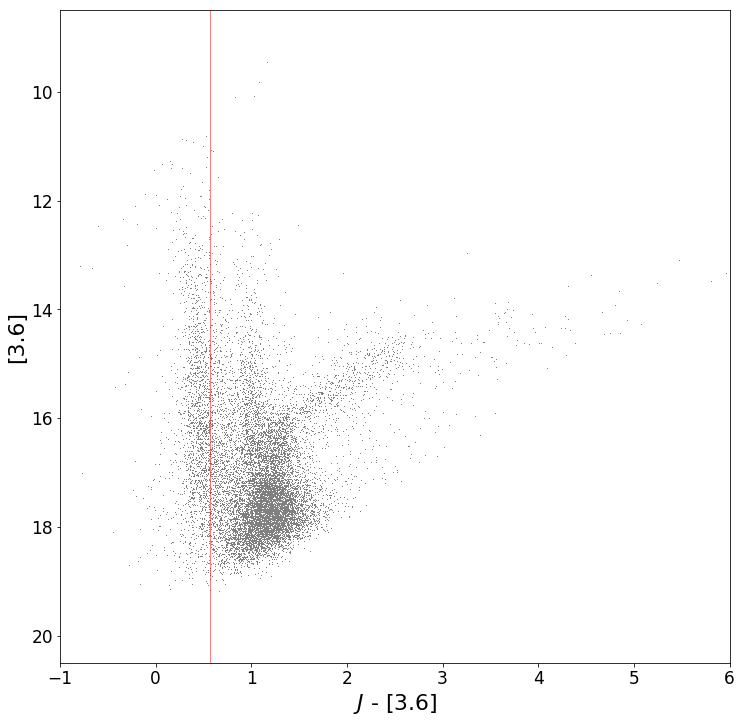

In [24]:
#15

# Check vertical line placement:

plot_CMD(xaxis,yaxis)

plt.axvline(x=boundary, color='r', linewidth=0.5)

# This cell plots the specific CMD being analyzed and overlays the vertical
# line from which the 3-sigma red-excess boundary is computed against.

In [25]:
#16

redlim = bound_shift(boundary)

print(redlim)

# This command assigns what Laurin is calling the "redlim = red limit", as the region
# of the CMD that will be flagged as "red-excess" for our classification purposes.

[nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.65555284314285711, nan, nan, nan, 0.7455278561428571, nan, 0.86551785714285701, 0.7455278561428571, nan, nan, nan, nan, nan, nan, 0.68554284864285708, 0.71553856314285713, 0.77552618814285712, 0.68554035114285705, 0.82052056464285705, 0.70053660264285711, 0.69304471764285713, 0.70059280914285704, 0.86551785714285701, 0.77552428314285704, 0.77560780764285708, 0.76057762501785708, 0.68554035114285705, 0.73890458580952378, 0.73068556814285712, 0.74562993789285703, 0.77569304614285706, 0.74022668405194803, 0.77263724304285708, 0.73822607064285706, 0.73217840268831158, 0.73808920274285705, 0.7457950318571428, 0.76834982589285716, 0.76792921851127816, 0.75312449358730149, 0.71810279289285717, 0.7719719184120879, 0.74031547901242234, 0.73176550086285708, 0.73599332842410714, 0.73306498252216745, 0.73656291537362639, 0.76129059106785713, 0.75985649589285709, 0.76440036468831163, 0.75921633359285701, 0.732722878507722, 0.74118563736507936, 0.73886

C:\Users\Laurin\WinPython-64bit-3.5.3.1Qt5\python-3.5.3.amd64\lib\site-packages\numpy\lib\nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
C:\Users\Laurin\WinPython-64bit-3.5.3.1Qt5\python-3.5.3.amd64\lib\site-packages\numpy\lib\nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
C:\Users\Laurin\WinPython-64bit-3.5.3.1Qt5\python-3.5.3.amd64\lib\site-packages\numpy\lib\nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
C:\Users\Laurin\WinPython-64bit-3.5.3.1Qt5\python-3.5.3.amd64\lib\site-packages\numpy\lib\nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
C:\Users\Laurin\WinPython-64bit-3.5.3.1Qt5\python-3.5.3.amd64\lib\site-packages\numpy\lib\nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", Runtim

In [26]:
#17

# If you want to plot the flagged points in another color for visibility:

red_x = []
red_y = []

k=0
for i in x_bin:
    c=0
    y_val = y_bin[k]
    for x in i:
        if x > redlim[k]:
            red_x.append(x)
            red_y.append(y_val[c])
            c=c+1
        else: 
            c=c+1
    k = k+1

# This cell takes all of the points that were flagged previously in the last cell
# as "red-excess" and appends them to the data set file.
# You can then overplot these onto the CMD at a later time if you wish
# (I think it's a cool visual effect to do so).

# Again, nothing in this cell is saved anywhere- it's purely a way to hold the values for points that are 
# about to be flagged so that I could double-check that things were being flagged properly -LG

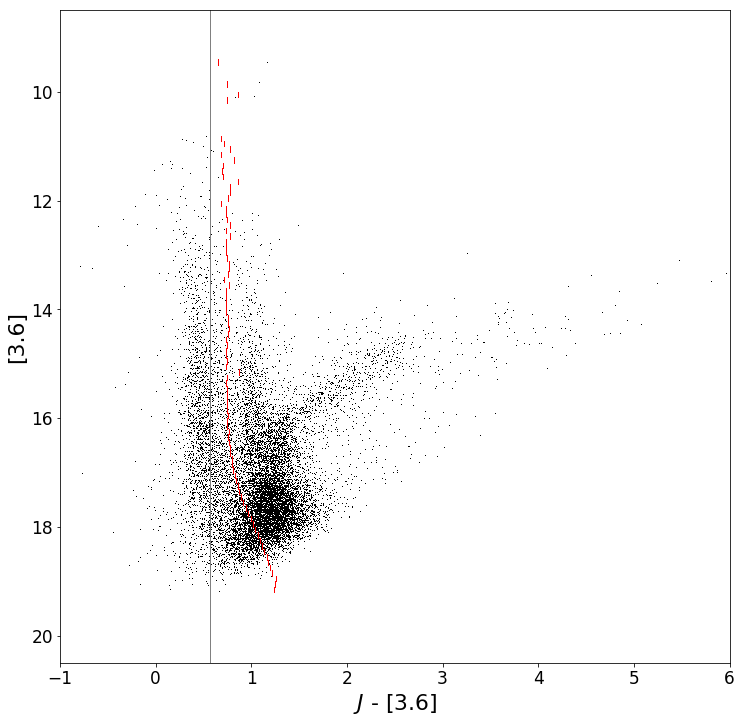

In [27]:
#18

# **********************************************************************************************************

# Confirm shifted boundaries:
#
### NB three CMDs use eightzero as y-axis!

plot_CMD(xaxis, yaxis, color='black')

# I'm going to split up the CMDs a little more below, because I think they have slightly different lower limits
# This is also where I'm going to define and calculate bin_lim (as used in cell #10) -LG

bin_lim = (low_lim - y1)/bin_size # when plotting & flagging, the function will only loop up to this bin before ending -LG

if yaxis is threesixMINUSeightzeroDATA.k80mag.values:
    plt.axhline(y=bin_lim, linewidth=1, c='r')
    for x in redlim[:bin_lim]:
        plt.plot((x,x), (y1, y1+bin_size), c='r', linewidth=1)
        y1 = y1 + bin_size
elif yaxis is jMINUSeightzeroDATA.k80mag.values:
    plt.axhline(y=bin_lim, linewidth=1, c='r')
    for x in redlim[:bin_lim]:
        plt.plot((x,x), (y1, y1+bin_size), c='r', linewidth=1)
        y1 = y1 + bin_size
elif yaxis is fourfiveMINUSeightzeroDATA.k80mag.values:
    plt.axhline(y=bin_lim, linewidth=1, c='r')
    for x in redlim[:bin_lim]:
        plt.plot((x,x), (y1, y1+bin_size), c='r', linewidth=1)
        y1 = y1 + bin_size
elif yaxis is eightzeroMINUStwentyfourDATA.k24mag.values:
    plt.axhline(y=bin_lim, linewidth=1, c='r')
    for x in redlim[:bin_lim]:
        plt.plot((x,x), (y1, y1+bin_size), c='r', linewidth=1)
        y1 = y1 + bin_size
else:
    for x in redlim:
        plt.plot((x,x), (y1, y1+bin_size), c='r', linewidth=1)
        y1 = y1 + bin_size

plt.axvline(x=boundary, color='grey', linewidth=1)
#plt.scatter(red_x, red_y, s=0.5, c='green') # plot flagged points in a different color

# Fixed this part so that it properly resets the y1 values- it needs to do this because the value of y1 gets changed above, 
# and if you happen to run this cell again without re-running the entire notebook, it won't plot correctly -LG
if yaxis is jMINUSthreesixDATA.k36mag.values:
    y1 = 8.5
elif yaxis is eightzeroMINUStwentyfourDATA.k24mag.values:
    y1 = 2.0
elif yaxis is fourfiveMINUSeightzeroDATA.k80mag.values:
    y1 = 7.5
else:
    y1 = 10.0

#plt.savefig('/Users/lgray/Documents/NGC6822_CMD/3Aug2018/K_vs_J-K_3sig.pdf')
### ^ don't forget to change this bit! -LG

# While the previous cell saves the red-excess points to the datatable file,
# this cell "confirms the shifted boundaries" by overplotting the red three-sigma
# line to the CMD so we can see where the red-excess points lie on the plot.
#
### ^ Are the "OR" commands valid here?  I added them on 4 October 2018
### to account for the fact that we have three CMDs with [8.0] as the y-axis.

# ^ I think the "OR" commands are fine since all of those functions will have some sort of lower magnitude limit for
# flagging evaluation, and I've modified it so the plotting & binning should stop at the right place automatically, even
# when the lower limit changes between CMDs -LG

In [28]:
#19

new_data = data_flag()
#print(new_data)

# This cell defines a value called 'new_data' which is to be appended to the datatable.
# To be honest, I'm not sure where this comes from.
# But this cell also prints out the *number* of red-excess points found in the CMD
# so that we can compare it to the number of sources overall.

Number of flagged points: 9311


In [29]:
#20

#save_data(new_data, column)

# This cell saves the 'new_data' into the datatable.

## Note that it will save this as a new column onto the end of an existing file, so don't uncomment & run this cell 
# until you're sure you want to save the data (i.e. after you've verified that the boundaries are correct) -LG

Okay, so I've made significant changes to cells #6, #10, #13, #14, #18, and an aesthetic change to cell #9.  I also left clarifying notes at the bottom of cells #12, #17, & #20.  I'm pretty sure that this should be able to run- definitely for the first two CMDs at least, but I feel good about the other four.  I don't have the data saved to my computer so I wasn't able to plot the vertical mean and lower limit lines onto the new CMDs (4 & 5), so you may have to take a close look at those and adjust them before you save any plots/data.  Let me know if you run into any issues or have a question about something!